### **Import Libraries**

In [1]:
import torch 
from datasets import load_dataset 
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
import torch 
import matplotlib.pyplot as plt 
from transformers import DataCollatorWithPadding
import os 
from pathlib import Path
import random 
from datasets import Dataset
import warnings
from functools import partial
from datasets import concatenate_datasets, DatasetDict
from functools import partial 
from IPython.display import display
from IPython.display import Markdown
import textwrap
from transformers import pipeline
from trl import SFTTrainer
# Filter out the specific warning
warnings.filterwarnings('ignore', message='Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.')

#### **Plotting**

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')
from matplotlib import font_manager 
locations =  './../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_60pt/Newsreader_60pt-LightItalic.ttf


#### **Key Parameters**

In [3]:
# This cell is tagged with `parameters`
model_name = 'distilbert/distilbert-base-uncased'
data_link = 'ppower1/instrument'
casusal_variable = False 
column = 'text'
num_epochs = 30
seed = 2 
max_tokens = 512

#### **Helper Functions**

In [4]:
def tokenize_function(examples, column='text'):
    return tokenizer(examples[column], padding="max_length", truncation=True, max_length=20)

#### **Model**

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **Load Data**

In [6]:
dummy_data = {
    "text": ["Yes, the Right to Counsel is in effect in the tenant's zip code. This is a summary process complaint for eviction due to nonpayment of rent in the State of Connecticut. The plaintiff, CROVANDER & Jordan, Properties, LLC, is the landlord, and the defendant, Damien Williams, is the tenant. The complaint states that on or about July 1, 2022, the plaintiff and defendant entered into an agreement, either orally or through a written lease, for the defendant to rent the premises located at 132 COOKE ST #1, WATERBURY CT. The term of the lease is one month, and the defendant agreed to pay $600.00 monthly on the 1st day of each month.\n\nHowever, the defendant has failed to pay the rent due on July 1, 2022, as agreed upon in the lease. On July 22, 2022, the plaintiff served a Notice to Quit (End) Possession on the defendant, requiring them to vacate the premises by July 30, 2022. The time given in the notice has passed, but the defendant has not moved out.\n\nThe plaintiff is seeking judgment for immediate possession of the premises and forfeiture of the defendant's possessions and personal effects since this is a nonresidential property. The complaint is signed by the plaintiff's attorney, Danam Giuliano, on August 1, 2022. True or False: The tenant has legal representation.", 
             "No, the Right to Counsel is not in effect in the tenant's zip code. This complaint was filed by Marina LLC against Jennifer Swift, John Doe, and Jane Doe in the Housing Session of the Superior Court in New Haven. The complaint is divided into three counts.\n\nCount One - Lapse of Time:\nThe plaintiff and defendants entered into a written lease agreement on August 1, 2021, for the premises located at [ADDRESS], First Floor, Room A, Hamden, CT. The lease was for a term of one year, with the defendants agreeing to pay $800.00 monthly on the first day of each month. The defendants have used and occupied the premises as agreed, and the lease was originally set to expire on July 31, 2022. However, either party had the right to terminate the lease with 60 days' notice. On January 3, 2022, the landlord gave notice that the lease would expire on March 3, 2022. The lease has now terminated by lapse of time, and on March 10, 2022, the plaintiff served a Notice to Quit (End) Possession on the defendants, requiring them to move out by April 12, 2022. Despite the notice, the defendants have not vacated the premises.\n\nCount Two - Right or Privilege Terminated:\nThis count incorporates paragraphs 1-5 of Count One and states that any right or privilege the defendants had to occupy the premises has been terminated.\n\nCount Three - No Right or Privilege:\nThis count also incorporates paragraphs 1-5 of Count One and alleges that John Doe and Jane Doe never had a right or privilege to occupy the premises.\n\nThe plaintiff requests judgment for immediate possession of the premises. The Tenant Right to Counsel Flyer, as required by State of Connecticut Public Act No. 21-34, section 1(10)(f)(3), is attached to the complaint in both English and Spanish. The complaint is dated April 18, 2022, and is filed by Zev Sandman, an attorney from Sandman Law Group LLC. The contact information for the plaintiff's attorney is provided at the end of the complaint. True or False: The tenant has legal representation."],
    "labels": np.array([1, 0]),
}
original_dataset = Dataset.from_dict(dummy_data)
original_dataset.set_format("pt")

# original_dataset = load_dataset(data_link)['train']
# original_dataset = original_dataset.shuffle(seed=42).select(range(32))

tokenized_dataset = original_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

#### **Hyperparameters**

In [7]:
def get_training_args(output_dir):
    return TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size= 4,
        num_train_epochs=num_epochs,
        logging_strategy="epoch",
        save_strategy="epoch",
        #lr_scheduler_type='' #  https://stackoverflow.com/questions/77792137/how-to-fix-the-learning-rate-for-huggingface%C2%B4s-trainer
)

trainer = Trainer(model=model,
                args=get_training_args("test_trainer"),
                train_dataset=tokenized_dataset
)

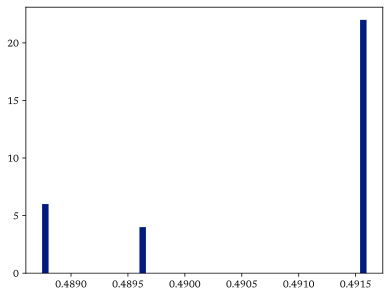

In [8]:
with torch.no_grad():
    original_predictions = trainer.predict(tokenized_dataset).predictions
    original_predictions = torch.nn.functional.softmax(torch.tensor(original_predictions), dim=1)[:,1].numpy()
plt.hist(original_predictions, bins=50)
plt.show()

In [9]:
trainer.train()

TrainOutput(global_step=240, training_loss=0.17401800553003946, metrics={'train_runtime': 37.1892, 'train_samples_per_second': 25.814, 'train_steps_per_second': 6.453, 'total_flos': 4967527449600.0, 'train_loss': 0.17401800553003946, 'epoch': 30.0})

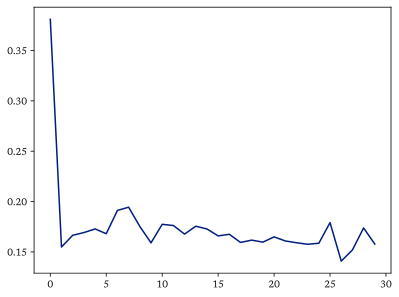

In [10]:
plt.plot([i['loss'] for i in trainer.state.log_history if 'loss' in i])
plt.show()

In [11]:
trainer.predict(tokenized_dataset)[0]

array([[ 2.53279  , -2.963848 ],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.53279  , -2.963848 ],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.53279  , -2.963848 ],
       [ 2.519401 , -2.9613764],
       [ 2.53279  , -2.963848 ],
       [ 2.2768855, -2.7080765],
       [ 2.519401 , -2.9613764],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.519401 , -2.9613764],
       [ 2.53279  , -2.963848 ],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.53279  , -2.963848 ],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2.2768855, -2.7080765],
       [ 2

In [12]:
np.mean(trainer.predict(tokenized_dataset)[1])

0.03125

In [13]:
trainer.predict(tokenized_dataset)[2]

{'test_loss': 0.16175352036952972,
 'test_runtime': 0.0251,
 'test_samples_per_second': 1275.034,
 'test_steps_per_second': 159.379}

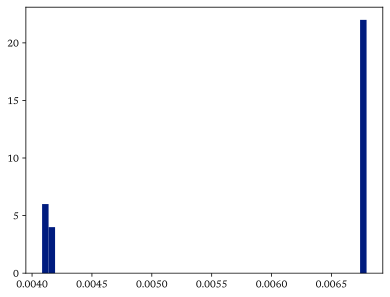

In [14]:
with torch.no_grad():
    original_predictions = trainer.predict(tokenized_dataset).predictions
    original_predictions = torch.nn.functional.softmax(torch.tensor(original_predictions), dim=1)[:,1].numpy()
plt.hist(original_predictions, bins=50)
plt.show()